In [ ]:
import pandas as pd

# Change to your actual paths
path_meta = "/content/drive/MyDrive/Patent_Data/g_patent.tsv.zip"
path_abs  = "/content/drive/MyDrive/Patent_Data/g_patent_abstract.tsv.zip"

# Read small chunks to avoid memory overload
meta = pd.read_csv(path_meta, sep="\t", compression="zip", usecols=["patent_id", "patent_title", "patent_date"], low_memory=False)
abs_df = pd.read_csv(path_abs, sep="\t", compression="zip", low_memory=False)

# Merge metadata with abstract text
merged = pd.merge(meta, abs_df, on="patent_id", how="inner")

# Filter by publication year (e.g., 2025)
merged["patent_date"] = pd.to_datetime(merged["patent_date"], errors="coerce")
merged = merged[merged["patent_date"].dt.year == 2025]

# Drop rows missing text
merged = merged.dropna(subset=["patent_title", "patent_abstract"])

# Optional: filter by domain keywords
domains = ["machine learning", "data engineering", "software engineering", "algorithm"]
pattern = "|".join(domains)
mask = merged["patent_title"].str.lower().str.contains(pattern) | merged["patent_abstract"].str.lower().str.contains(pattern)
filtered = merged[mask]

# Rename and save
filtered = filtered.rename(columns={
    "patent_id": "patent_id",
    "patent_title": "title",
    "patent_abstract": "abstract",
    "patent_date": "pub_date"
})

filtered.to_csv("/content/filtered_patents_2025.csv", index=False)
print("✅ Saved filtered_patents_2025.csv with", len(filtered), "rows")
print(filtered.head())


✅ Saved filtered_patents_2025.csv with 3954 rows
        patent_id   pub_date  \
1681039  11694774 2025-06-17   
2167650  12186050 2025-01-07   
2167662  12186062 2025-01-07   
2167689  12186089 2025-01-07   
2167709  12186109 2025-01-07   

                                                     title  \
1681039  Platform for perpetual clinical collaboration ...   
2167650           Biometric monitoring systems and methods   
2167662  Systems and methods for processing electronic ...   
2167689  Systems and methods for controlling a device b...   
2167709  Predictive monitoring of the glucose-insulin e...   

                                                  abstract  
1681039  Described are web-based clinical data stores; ...  
2167650  Computer implemented biometric methods and sys...  
2167662  Systems and methods are disclosed for determin...  
2167689  Systems, methods, and apparatus for controllin...  
2167709  There is a need for more effective and efficie...  


In [ ]:
!pip install openai pandas numpy matplotlib faiss-cpu tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 79.3 MB/s eta 0:00:00


Rows: 3954
  patent_id    pub_date                                              title  \
0  11694774  2025-06-17  Platform for perpetual clinical collaboration ...   
1  12186050  2025-01-07           Biometric monitoring systems and methods   
2  12186062  2025-01-07  Systems and methods for processing electronic ...   

                                            abstract  
0  Described are web-based clinical data stores; ...  
1  Computer implemented biometric methods and sys...  
2  Systems and methods are disclosed for determin...  
✅ 3905 usable patents after cleaning

🔍 Query: machine learning system for optimizing cloud resources

1. Frontend storage port rebalancing and allocation using machine learning techniques
   The technology described herein is directed towards intelligent storage frontend port re-balancing/allocation in a datacenter's port groups having data maintained in masking view data. Artificial intelligence/machine learning (AI/ML) models accurately monitor the 

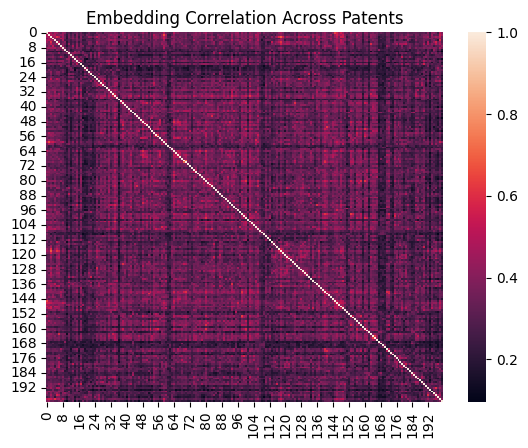

In [ ]:
# =========================================================
# PATENT SEMANTIC SEARCH (using OpenAI embeddings)
# =========================================================

import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
import faiss

# =========================================================
# Load real patent data (from your filtered_patents_2025.csv)
# =========================================================

import pandas as pd

# Path to your processed CSV
DATA_PATH = "/content/filtered_patents_2025.csv"

# Load CSV
df = pd.read_csv(DATA_PATH)

# Quick sanity check
print("Rows:", len(df))
print(df.head(3))

# Clean text and fill missing values
df["title"] = df["title"].fillna("").astype(str)
df["abstract"] = df["abstract"].fillna("").astype(str)
df["text"] = (df["title"] + ". " + df["abstract"]).str.strip()

# Optional: Drop duplicates or empty texts
df = df[df["text"].str.len() > 50].drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f"✅ {len(df)} usable patents after cleaning")

# (If you just want a tiny subset for testing)
# df = df.sample(n=100, random_state=42).reset_index(drop=True)


# ---- SETUP ----
os.environ["OPENAI_API_KEY"] = "XXXXXXXXXXXXXXXXXXX"   # replace with your key
client = OpenAI()

# ---- EMBEDDING GENERATION ----
from openai import OpenAI
import numpy as np
import faiss

client = OpenAI(api_key="XXXXXXXXXXXXXXX")

def get_embedding(text):
    return client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    ).data[0].embedding

# Generate embeddings (try with a small subset first)
subset = df.head(200).copy()
# or df.sample(500)
subset["embedding"] = subset["text"].apply(get_embedding)
emb_matrix = np.vstack(subset["embedding"].values).astype("float32")

# Build FAISS index
index = faiss.IndexFlatL2(emb_matrix.shape[1])
index.add(emb_matrix)

# ---- SEMANTIC SEARCH ----
def search_patents(query, k=3):
    q_emb = np.array(get_embedding(query), dtype="float32").reshape(1, -1)
    D, I = index.search(q_emb, k)
    results = subset.iloc[I[0]]
    print(f"\n🔍 Query: {query}\n")
    for rank, (_, row) in enumerate(results.iterrows(), 1):
        print(f"{rank}. {row['title']}")
        print(f"   {row['abstract'][:500]}...\n")
    return results

# Example query
search_patents("machine learning system for optimizing cloud resources")

# ---- VISUALIZATION ----
import seaborn as sns
sns.heatmap(np.corrcoef(emb_matrix))
plt.title("Embedding Correlation Across Patents")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from openai import OpenAI
from tqdm import tqdm
import os

# Setup
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))  # ensure you set this env var
DATA_PATH = "/content/filtered_patents_2025.csv"
SAVE_META = "/content/drive/MyDrive/Patent_Data/patent_metadata.csv"
SAVE_EMB  = "/content/drive/MyDrive/Patent_Data/embeddings.npy"

df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=["abstract"]).reset_index(drop=True)  # ensure abstracts exist
df["text"] = (df["title"] + ". " + df["abstract"]).astype(str)

embs = []
for i in tqdm(range(0, len(df), 50)):
    batch = df["text"].iloc[i:i+50].tolist()
    resp = client.embeddings.create(model="text-embedding-3-large", input=batch)
    batch_emb = [r.embedding for r in resp.data]
    embs.extend(batch_emb)
    print(f"Processed {i+len(batch_emb)}/{len(df)}")

print("✅ Total embeddings:", len(embs))

  1%|▏         | 1/80 [00:01<01:57,  1.48s/it]

Processed 50/3954


  2%|▎         | 2/80 [00:02<01:48,  1.40s/it]

Processed 100/3954


  4%|▍         | 3/80 [00:04<01:49,  1.42s/it]

Processed 150/3954


  5%|▌         | 4/80 [00:05<01:43,  1.36s/it]

Processed 200/3954


  6%|▋         | 5/80 [00:06<01:43,  1.38s/it]

Processed 250/3954


  8%|▊         | 6/80 [00:08<01:44,  1.41s/it]

Processed 300/3954


  9%|▉         | 7/80 [00:09<01:37,  1.33s/it]

Processed 350/3954


 10%|█         | 8/80 [00:11<01:41,  1.40s/it]

Processed 400/3954


 11%|█▏        | 9/80 [00:12<01:32,  1.30s/it]

Processed 450/3954


 12%|█▎        | 10/80 [00:13<01:31,  1.31s/it]

Processed 500/3954


 14%|█▍        | 11/80 [00:14<01:29,  1.29s/it]

Processed 550/3954


 15%|█▌        | 12/80 [00:15<01:19,  1.17s/it]

Processed 600/3954


 16%|█▋        | 13/80 [00:17<01:21,  1.21s/it]

Processed 650/3954


 18%|█▊        | 14/80 [00:18<01:22,  1.25s/it]

Processed 700/3954


 19%|█▉        | 15/80 [00:19<01:18,  1.21s/it]

Processed 750/3954


 20%|██        | 16/80 [00:20<01:19,  1.24s/it]

Processed 800/3954


 21%|██▏       | 17/80 [00:21<01:05,  1.05s/it]

Processed 850/3954


 22%|██▎       | 18/80 [00:22<01:10,  1.14s/it]

Processed 900/3954


 24%|██▍       | 19/80 [00:24<01:18,  1.29s/it]

Processed 950/3954


 25%|██▌       | 20/80 [00:25<01:14,  1.24s/it]

Processed 1000/3954


 26%|██▋       | 21/80 [00:26<01:17,  1.31s/it]

Processed 1050/3954


 28%|██▊       | 22/80 [00:28<01:13,  1.27s/it]

Processed 1100/3954


 29%|██▉       | 23/80 [00:29<01:15,  1.32s/it]

Processed 1150/3954


 30%|███       | 24/80 [00:30<01:03,  1.13s/it]

Processed 1200/3954


 31%|███▏      | 25/80 [00:30<00:52,  1.04it/s]

Processed 1250/3954


 32%|███▎      | 26/80 [00:32<00:55,  1.03s/it]

Processed 1300/3954


 34%|███▍      | 27/80 [00:32<00:49,  1.07it/s]

Processed 1350/3954


 35%|███▌      | 28/80 [00:33<00:51,  1.02it/s]

Processed 1400/3954


 36%|███▋      | 29/80 [00:34<00:45,  1.11it/s]

Processed 1450/3954


 38%|███▊      | 30/80 [00:36<00:53,  1.08s/it]

Processed 1500/3954


 39%|███▉      | 31/80 [00:36<00:50,  1.02s/it]

Processed 1550/3954


 40%|████      | 32/80 [00:37<00:42,  1.14it/s]

Processed 1600/3954


 41%|████▏     | 33/80 [00:38<00:44,  1.05it/s]

Processed 1650/3954


 42%|████▎     | 34/80 [00:39<00:45,  1.01it/s]

Processed 1700/3954


 44%|████▍     | 35/80 [00:40<00:38,  1.17it/s]

Processed 1750/3954


 45%|████▌     | 36/80 [00:40<00:33,  1.30it/s]

Processed 1800/3954


 46%|████▋     | 37/80 [00:41<00:30,  1.40it/s]

Processed 1850/3954


 48%|████▊     | 38/80 [00:42<00:40,  1.03it/s]

Processed 1900/3954


 49%|████▉     | 39/80 [00:43<00:35,  1.15it/s]

Processed 1950/3954


 50%|█████     | 40/80 [00:44<00:35,  1.12it/s]

Processed 2000/3954


 51%|█████▏    | 41/80 [00:45<00:37,  1.03it/s]

Processed 2050/3954


 52%|█████▎    | 42/80 [00:46<00:34,  1.09it/s]

Processed 2100/3954


 54%|█████▍    | 43/80 [00:47<00:34,  1.08it/s]

Processed 2150/3954


 55%|█████▌    | 44/80 [00:48<00:31,  1.13it/s]

Processed 2200/3954


 56%|█████▋    | 45/80 [00:48<00:28,  1.22it/s]

Processed 2250/3954


 57%|█████▊    | 46/80 [00:49<00:25,  1.34it/s]

Processed 2300/3954


 59%|█████▉    | 47/80 [00:50<00:24,  1.36it/s]

Processed 2350/3954


 60%|██████    | 48/80 [00:50<00:22,  1.41it/s]

Processed 2400/3954


 61%|██████▏   | 49/80 [00:51<00:22,  1.37it/s]

Processed 2450/3954


 62%|██████▎   | 50/80 [00:52<00:20,  1.47it/s]

Processed 2500/3954


 64%|██████▍   | 51/80 [00:53<00:28,  1.02it/s]

Processed 2550/3954


 65%|██████▌   | 52/80 [00:55<00:31,  1.12s/it]

Processed 2600/3954


 66%|██████▋   | 53/80 [00:56<00:33,  1.23s/it]

Processed 2650/3954


 68%|██████▊   | 54/80 [00:57<00:31,  1.22s/it]

Processed 2700/3954


 69%|██████▉   | 55/80 [00:59<00:31,  1.24s/it]

Processed 2750/3954


 70%|███████   | 56/80 [00:59<00:25,  1.08s/it]

Processed 2800/3954


 71%|███████▏  | 57/80 [01:01<00:26,  1.14s/it]

Processed 2850/3954


 72%|███████▎  | 58/80 [01:02<00:27,  1.27s/it]

Processed 2900/3954


 74%|███████▍  | 59/80 [01:04<00:27,  1.30s/it]

Processed 2950/3954


 75%|███████▌  | 60/80 [01:05<00:24,  1.24s/it]

Processed 3000/3954


 76%|███████▋  | 61/80 [01:06<00:24,  1.30s/it]

Processed 3050/3954


 78%|███████▊  | 62/80 [01:07<00:23,  1.29s/it]

Processed 3100/3954


 79%|███████▉  | 63/80 [01:09<00:21,  1.25s/it]

Processed 3150/3954


 80%|████████  | 64/80 [01:10<00:21,  1.32s/it]

Processed 3200/3954


 81%|████████▏ | 65/80 [01:11<00:18,  1.24s/it]

Processed 3250/3954


 82%|████████▎ | 66/80 [01:12<00:15,  1.09s/it]

Processed 3300/3954


 84%|████████▍ | 67/80 [01:13<00:15,  1.15s/it]

Processed 3350/3954


 85%|████████▌ | 68/80 [01:14<00:13,  1.09s/it]

Processed 3400/3954


 86%|████████▋ | 69/80 [01:15<00:11,  1.08s/it]

Processed 3450/3954


 88%|████████▊ | 70/80 [01:17<00:11,  1.16s/it]

Processed 3500/3954


 89%|████████▉ | 71/80 [01:17<00:09,  1.06s/it]

Processed 3550/3954


 90%|█████████ | 72/80 [01:18<00:08,  1.08s/it]

Processed 3600/3954


 91%|█████████▏| 73/80 [01:20<00:08,  1.23s/it]

Processed 3650/3954


 92%|█████████▎| 74/80 [01:21<00:07,  1.25s/it]

Processed 3700/3954


 94%|█████████▍| 75/80 [01:23<00:06,  1.39s/it]

Processed 3750/3954


 95%|█████████▌| 76/80 [01:24<00:05,  1.38s/it]

Processed 3800/3954


 96%|█████████▋| 77/80 [01:26<00:03,  1.29s/it]

Processed 3850/3954


 98%|█████████▊| 78/80 [01:27<00:02,  1.36s/it]

Processed 3900/3954


 99%|█████████▉| 79/80 [01:29<00:01,  1.44s/it]

Processed 3950/3954


100%|██████████| 80/80 [01:29<00:00,  1.12s/it]

Processed 3954/3954
✅ Total embeddings: 3954


In [ ]:
emb_matrix = np.vstack(embs).astype("float32")

# Save
np.save(SAVE_EMB, emb_matrix)
df.drop(columns=["text"]).to_csv(SAVE_META, index=False)
print("✅ Saved metadata and embeddings")

✅ Saved metadata and embeddings


In [ ]:
import numpy as np
emb = np.load("/content/drive/MyDrive/Patent_Data/embeddings.npy")
emb.shape


(3954, 3072)

In [ ]:
import pandas as pd

META_PATH = "/content/drive/MyDrive/Patent_Data/patent_metadata.csv"
CPC_PATH  = "/content/drive/MyDrive/Patent_Data/g_cpc_current.tsv.zip"
OUT_PATH  = "/content/drive/MyDrive/Patent_Data/metadata_with_cpc.csv"

meta = pd.read_csv(META_PATH, dtype=str)
cpc  = pd.read_csv(
    CPC_PATH, sep="\t", compression="zip", dtype=str,
    usecols=["patent_id", "cpc_section", "cpc_class", "cpc_subclass", "cpc_group"]
)

# Combine into one field
cpc["cpc_code"] = (
    cpc["cpc_section"].fillna("") +
    cpc["cpc_class"].fillna("") +
    cpc["cpc_subclass"].fillna("") +
    cpc["cpc_group"].fillna("")
)

# Keep only one CPC per patent (e.g., primary sequence or first occurrence)
cpc_unique = cpc.drop_duplicates(subset=["patent_id"]).copy()

# Merge
merged = meta.merge(cpc_unique[["patent_id", "cpc_code"]], on="patent_id", how="left")

merged.to_csv(OUT_PATH, index=False)
print(f"✅ Merged CPC codes for {len(merged)} patents")
merged.head()


#cpc  = pd.read_csv(CPC_PATH, sep="\t", compression="zip", usecols=["patent_id","cpc_subgroup_id"], dtype=str, low_memory=False)



✅ Merged CPC codes for 3954 patents


,patent_id,pub_date,title,abstract,cpc_code
0,11694774,2025-06-17,Platform for perpetual clinical collaboration ...,Described are web-based clinical data stores; ...,GG16G16HG16H10/60
1,12186050,2025-01-07,Biometric monitoring systems and methods,Computer implemented biometric methods and sys...,AA61A61BA61B5/0022
2,12186062,2025-01-07,Systems and methods for processing electronic ...,Systems and methods are disclosed for determin...,AA61A61BA61B5/026
3,12186089,2025-01-07,Systems and methods for controlling a device b...,"Systems, methods, and apparatus for controllin...",AA61A61BA61B5/374
4,12186109,2025-01-07,Predictive monitoring of the glucose-insulin e...,There is a need for more effective and efficie...,AA61A61BA61B5/7275


In [ ]:
!pip install gradio faiss-cpu pandas numpy openai --quiet

import gradio as gr
import pandas as pd
import numpy as np
import faiss
from openai import OpenAI

# ====== Load data ======
META_PATH = "/content/drive/MyDrive/Patent_Data/metadata_with_cpc.csv"
EMB_PATH  = "/content/drive/MyDrive/Patent_Data/embeddings.npy"

meta = pd.read_csv(META_PATH, dtype=str).fillna("")
embs = np.load(EMB_PATH).astype("float32")

# Normalize for cosine similarity
faiss.normalize_L2(embs)
index = faiss.IndexFlatIP(embs.shape[1])
index.add(embs)
print("✅ FAISS index built with", index.ntotal, "patents")

client = OpenAI(api_key="XXXXXXXXXXXXXXXXXXXXXX")  # or from environment


# ====== Helper functions ======
def get_query_embedding(text):
    """Get embedding for a query using OpenAI."""
    res = client.embeddings.create(model="text-embedding-3-large", input=text)
    return np.array(res.data[0].embedding, dtype="float32").reshape(1, -1)


def search_patents(query, top_k=5):
    """Return top matching patents as formatted HTML cards."""
    q_emb = get_query_embedding(query)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, top_k)

    results = []
    for rank, idx in enumerate(I[0]):
        row = meta.iloc[idx]
        score = round(float(D[0][rank]), 3)
        results.append(
            f"""
            <div style='border:1px solid #ccc; border-radius:10px; padding:12px; margin:10px; background-color:#f9f9f9;'>
                <h3 style='color:#2a3f5f;'>{row['title']}</h3>
                <p><b>Patent ID:</b> {row['patent_id']}<br>
                   <b>Published:</b> {row.get('pub_date', 'N/A')}<br>
                   <b>CPC Code:</b> {row.get('cpc_code', 'N/A')}<br>
                   <b>Similarity Score:</b> {score}<br>
                   <b>Link:</b> <i>(Coming soon)</i></p>
                <p style='text-align:justify;'>{row['abstract'][:500]}...</p>
            </div>
            """
        )

    return "\n".join(results)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 70.6 MB/s eta 0:00:00
✅ FAISS index built with 3954 patents


In [ ]:
# ====== Gradio UI ======
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue")) as demo:
    gr.Markdown("## 🔍 Patent Semantic Search (2025 Data)")
    query = gr.Textbox(label="Enter a keyword or question:")
    search_btn = gr.Button("Search Patents")
    output = gr.HTML(label="Results")

    search_btn.click(search_patents, inputs=query, outputs=output)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b452ee7f9698004de9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Industry and Commercialization

In [ ]:
import pandas as pd
import os

# === Base filtered patent IDs ===
meta = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_patents_2025.csv", dtype=str)
patent_ids = set(meta["patent_id"].astype(str).unique())
print(f"✅ Base patent IDs: {len(patent_ids)}")

# === Output folder on Drive ===
out_dir = "/content/drive/MyDrive/Patent_Data/filtered_chunks"
os.makedirs(out_dir, exist_ok=True)

# --- Helper function: read in chunks and auto-save ---
def filter_and_save_zip(path, usecols, out_csv, chunksize=100_000):
    chunks, i, total = [], 0, 0
    print(f"\n🔹 Processing {os.path.basename(path)} ...")
    for chunk in pd.read_csv(path, sep="\t", compression="zip", dtype=str,
                             usecols=usecols, chunksize=chunksize, low_memory=False):
        i += 1
        chunk = chunk[chunk["patent_id"].isin(patent_ids)]
        total += len(chunk)
        if not chunk.empty:
            chunks.append(chunk)
        if i % 5 == 0:
            print(f"  → processed {i*chunksize:,} rows, kept {total:,}")
        # Auto-save intermediate every 500k rows processed
        if total > 0 and total % 500_000 == 0:
            pd.concat(chunks).to_csv(out_csv, mode='a', index=False, header=not os.path.exists(out_csv))
            chunks.clear()
    # Save remaining data
    if chunks:
        pd.concat(chunks).to_csv(out_csv, mode='a', index=False, header=not os.path.exists(out_csv))
    print(f"✅ Done: saved {total:,} filtered rows → {out_csv}")
    return total

# --- CPC ---
cpc_cols = ["patent_id","cpc_section","cpc_class","cpc_subclass","cpc_group","cpc_type"]
filter_and_save_zip(
    "/content/drive/MyDrive/Patent_Data/g_cpc_current.tsv.zip",
    cpc_cols,
    f"{out_dir}/cpc_filtered.csv"
)

# --- Inventors ---
inv_cols = ["patent_id","inventor_sequence","disambig_inventor_name_first",
            "disambig_inventor_name_last","gender_code","location_id"]
filter_and_save_zip(
    "/content/drive/MyDrive/Patent_Data/g_inventor_disambiguated.tsv.zip",
    inv_cols,
    f"{out_dir}/inventor_filtered.csv"
)

# --- Assignees ---
ass_cols = ["patent_id","assignee_sequence","disambig_assignee_individual_name_first",
            "disambig_assignee_individual_name_last","disambig_assignee_organization",
            "assignee_type","location_id"]
filter_and_save_zip(
    "/content/drive/MyDrive/Patent_Data/g_assignee_disambiguated.tsv.zip",
    ass_cols,
    f"{out_dir}/assignee_filtered.csv"
)


✅ Base patent IDs: 3954

🔹 Processing g_cpc_current.tsv.zip ...
  → processed 500,000 rows, kept 0
  → processed 1,000,000 rows, kept 0
  → processed 1,500,000 rows, kept 0
  → processed 2,000,000 rows, kept 0
  → processed 2,500,000 rows, kept 0
  → processed 3,000,000 rows, kept 0
  → processed 3,500,000 rows, kept 0
  → processed 4,000,000 rows, kept 0
  → processed 4,500,000 rows, kept 0
  → processed 5,000,000 rows, kept 0
  → processed 5,500,000 rows, kept 0
  → processed 6,000,000 rows, kept 0
  → processed 6,500,000 rows, kept 0
  → processed 7,000,000 rows, kept 0
  → processed 7,500,000 rows, kept 0
  → processed 8,000,000 rows, kept 0
  → processed 8,500,000 rows, kept 0
  → processed 9,000,000 rows, kept 0
  → processed 9,500,000 rows, kept 0
  → processed 10,000,000 rows, kept 0
  → processed 10,500,000 rows, kept 0
  → processed 11,000,000 rows, kept 0
  → processed 11,500,000 rows, kept 0
  → processed 12,000,000 rows, kept 0
  → processed 12,500,000 rows, kept 0
  → pro

3957

In [ ]:
import pandas as pd

loc_cols = [
    "location_id",
    "disambig_city",
    "disambig_state",
    "disambig_country",
    "latitude",
    "longitude",
    "county",
    "state_fips",
    "county_fips"
]

loc = pd.read_csv(
    "/content/drive/MyDrive/Patent_Data/g_location_disambiguated.tsv.zip",
    sep="\t", compression="zip", dtype=str, usecols=loc_cols
)

# Optional — combine for readable display
loc["location_full_info"] = (
    loc["disambig_city"].fillna("") + ", " +
    loc["disambig_state"].fillna("") + ", " +
    loc["disambig_country"].fillna("")
).str.strip(", ")

print(f"✅ Loaded location data: {len(loc):,} rows")
loc.head(3)



✅ Loaded location data: 98,705 rows


,location_id,disambig_city,disambig_state,disambig_country,latitude,longitude,county,state_fips,county_fips,location_full_info
0,00235947-16c8-11ed-9b5f-1234bde3cd05,Westfield,PA,US,41.9192368,-77.5388744,Tioga,42,117,"Westfield, PA, US"
1,00236a27-16c8-11ed-9b5f-1234bde3cd05,Helfenstein,PA,US,40.7504993,-76.4473336,Schuylkill County,42,107,"Helfenstein, PA, US"
2,00236f47-16c8-11ed-9b5f-1234bde3cd05,Pine Forge,PA,US,40.2819205,-75.6922357,Berks County,42,011,"Pine Forge, PA, US"


In [ ]:

loc.to_csv(f"{out_dir}/location_filtered.csv", index=False)
print(f"✅ Locations saved: {len(loc)} rows")

✅ Locations saved: 98705 rows


In [ ]:
import pandas as pd

# === Load Base Metadata ===
meta = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_patents_2025.csv", dtype=str)
print(f"✅ Base patents: {len(meta):,}")

# === Load Filtered Data ===
cpc = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_chunks/cpc_filtered.csv", dtype=str)
inv = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_chunks/inventor_filtered.csv", dtype=str)
ass = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_chunks/assignee_filtered.csv", dtype=str)
loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_chunks/location_filtered.csv", dtype=str)

print(f"📦 Loaded CPC: {len(cpc):,}, Inventors: {len(inv):,}, Assignees: {len(ass):,}, Locations: {len(loc):,}")

# === CPC full info ===
cpc["cpc_full_info"] = (
    cpc["cpc_section"].fillna("") + " " +
    cpc["cpc_class"].fillna("") + " " +
    cpc["cpc_subclass"].fillna("") + " " +
    cpc["cpc_group"].fillna("") + " (" +
    cpc["cpc_type"].fillna("") + ")"
).str.strip()
cpc_summary = cpc.groupby("patent_id")["cpc_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()

# === Inventor full info ===
inv["inventor_full_info"] = (
    inv["disambig_inventor_name_first"].fillna("") + " " +
    inv["disambig_inventor_name_last"].fillna("") +
    " (Gender: " + inv["gender_code"].fillna("") +
    ", LocationID: " + inv["location_id"].fillna("") + ")"
).str.strip()
inv_summary = inv.groupby("patent_id")["inventor_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()

# === Assignee full info ===
ass["assignee_full_info"] = (
    ass["disambig_assignee_organization"].fillna("") + " " +
    ass["disambig_assignee_individual_name_first"].fillna("") + " " +
    ass["disambig_assignee_individual_name_last"].fillna("") +
    " (Type: " + ass["assignee_type"].fillna("") +
    ", LocationID: " + ass["location_id"].fillna("") + ")"
).str.strip()
ass_summary = ass.groupby("patent_id")["assignee_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()

# === Location readable info ===
loc["location_full_info"] = (
    loc["disambig_city"].fillna("") + ", " +
    loc["disambig_state"].fillna("") + ", " +
    loc["disambig_country"].fillna("")
).str.strip(", ")
loc_summary = loc[["location_id", "location_full_info"]].drop_duplicates()

# === Merge All Summaries ===
merged = meta.merge(cpc_summary, on="patent_id", how="left") \
              .merge(inv_summary, on="patent_id", how="left") \
              .merge(ass_summary, on="patent_id", how="left")

# Merge representative location info (from inventor/assignee)
merged = merged.merge(inv[["patent_id", "location_id"]], on="patent_id", how="left") \
               .merge(loc_summary, on="location_id", how="left")

# === Clean + Save ===
merged.to_csv("/content/drive/MyDrive/Patent_Data/patents_enriched_for_embeddings.csv", index=False)
print(f"✅ Final enriched file ready: {len(merged):,} patents")
print("📁 Saved to: /content/drive/MyDrive/Patent_Data/patents_enriched_for_embeddings.csv")


✅ Base patents: 3,954
📦 Loaded CPC: 34,612, Inventors: 14,120, Assignees: 3,957, Locations: 98,705
✅ Final enriched file ready: 14,120 patents
📁 Saved to: /content/drive/MyDrive/Patent_Data/patents_enriched_for_embeddings.csv


In [ ]:
import pandas as pd

# === 1. Load Base Patent Metadata ===
meta = pd.read_csv("/content/drive/MyDrive/Patent_Data/filtered_patents_2025.csv", dtype=str)
print(f"✅ Loaded base patents: {len(meta)}")

# === 2. Load CPC Data ===
cpc = pd.read_csv(
    "/content/drive/MyDrive/Patent_Data/g_cpc_current.tsv.zip",
    sep="\t", compression="zip", dtype=str,
    usecols=["patent_id", "cpc_section", "cpc_class", "cpc_subclass", "cpc_group", "cpc_type"],
    low_memory=False
)
cpc["cpc_full_info"] = (
    cpc["cpc_section"].fillna("") + " " +
    cpc["cpc_class"].fillna("") + " " +
    cpc["cpc_subclass"].fillna("") + " " +
    cpc["cpc_group"].fillna("") + " (" +
    cpc["cpc_type"].fillna("") + ")"
).str.strip()
cpc_summary = cpc.groupby("patent_id")["cpc_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()

# === 3. Load Inventor Data ===
inv = pd.read_csv(
    "/content/drive/MyDrive/Patent_Data/g_inventor_disambiguated.tsv.zip",
    sep="\t", compression="zip", dtype=str,
    usecols=["patent_id", "inventor_sequence", "disambig_inventor_name_first",
             "disambig_inventor_name_last", "gender_code", "location_id"],
    low_memory=False
)
inv["inventor_full_info"] = (
    inv["disambig_inventor_name_first"].fillna("") + " " +
    inv["disambig_inventor_name_last"].fillna("") + " (" +
    inv["gender_code"].fillna("") + ", LocID: " +
    inv["location_id"].fillna("") + ")"
).str.strip()
inv_summary = inv.groupby("patent_id")["inventor_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()

# === 4. Load Assignee Data ===
ass = pd.read_csv(
    "/content/drive/MyDrive/Patent_Data/g_assignee_disambiguated.tsv.zip",
    sep="\t", compression="zip", dtype=str,
    usecols=["patent_id", "assignee_sequence", "disambig_assignee_individual_name_first",
             "disambig_assignee_individual_name_last", "disambig_assignee_organization",
             "assignee_type", "location_id"],
    low_memory=False
)
ass["assignee_full_info"] = (
    ass["disambig_assignee_organization"].fillna("") + " " +
    ass["disambig_assignee_individual_name_first"].fillna("") + " " +
    ass["disambig_assignee_individual_name_last"].fillna("") +
    " (Type: " + ass["assignee_type"].fillna("") + ", LocID: " + ass["location_id"].fillna("") + ")"
).str.strip()
ass_summary = ass.groupby("patent_id")["assignee_full_info"].apply(lambda x: "; ".join(x.dropna().unique())).reset_index()




✅ Loaded base patents: 3954


KeyboardInterrupt: 

In [ ]:
# === 5. Load Location Data ===
loc = pd.read_csv(
    "/content/drive/MyDrive/Patent_Data/g_location_disambiguated.tsv.zip",
    sep="\t", compression="zip", dtype=str,
    usecols=["location_id", "city", "state", "country"],
    low_memory=False
)
loc["location_full_info"] = (
    loc["city"].fillna("") + ", " + loc["state"].fillna("") + ", " + loc["country"].fillna("")
).str.strip()

# === 6. Merge Everything Together ===
merged = meta.merge(cpc_summary, on="patent_id", how="left") \
              .merge(inv_summary, on="patent_id", how="left") \
              .merge(ass_summary, on="patent_id", how="left")

# Optional: attach readable location summary (using first inventor’s location if present)
merged = merged.merge(inv[["patent_id", "location_id"]], on="patent_id", how="left")
merged = merged.merge(loc[["location_id", "location_full_info"]], on="location_id", how="left")

# === 7. Save for Embedding ===
merged.to_csv("/content/drive/MyDrive/Patent_Data/patents_enriched_for_embeddings.csv", index=False)
print(f"✅ Final enriched file ready for embeddings: {len(merged)} rows")

In [ ]:
import pandas as pd

# Load your existing file
df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_cpc.csv")

clean_rows = []

for idx, row in df.iterrows():
    patent = str(row["start_id"])

    # Split the CPC list into individual codes
    raw_codes = str(row["end_id"]).split(";")

    for code in raw_codes:
        code = code.strip()
        if code and code.lower() != "nan":
            clean_rows.append([patent, code])

# Build clean dataframe
clean_df = pd.DataFrame(clean_rows, columns=["start_id", "end_id"])

# Remove duplicates (same patent → CPC code)
clean_df = clean_df.drop_duplicates()

# Add relationship type
clean_df["type"] = "CLASSIFIED_AS"

# Sort by patent ID
clean_df = clean_df.sort_values(by="start_id")

# Save final file
clean_df.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_cpc_clean.csv", index=False)

print("Saved patent_cpc_clean.csv with", len(clean_df), "rows")


Saved patent_cpc_clean.csv with 27133 rows


In [ ]:
import pandas as pd

# Load the file
df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_inventor.csv")

clean_rows = []

for idx, row in df.iterrows():
    patent = str(row["start_id"])

    # split inventor names by semicolon
    raw_names = str(row["end_id"]).split(";")

    for name in raw_names:
        name = name.strip()
        if name and name.lower() != "nan":
            clean_rows.append([patent, name])

# Build clean dataframe
clean_df = pd.DataFrame(clean_rows, columns=["start_id", "end_id"])

# Remove duplicate relationships
clean_df = clean_df.drop_duplicates()

# Add relationship type
clean_df["type"] = "PATENTED_BY"

# Sort by patent_id
clean_df = clean_df.sort_values(by="start_id")

# Save the fixed file
clean_df.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_inventor_clean.csv", index=False)

print("Saved patent_inventor_clean.csv with", len(clean_df), "rows")


Saved patent_inventor_clean.csv with 95300 rows


In [ ]:
!pip install pycountry


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pycountry

# Load your file
df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes.csv", dtype=str)

# Extract unique country codes
df["temp"] = df["location"].str.split(",", expand=True)[2]
df["temp"] = df["temp"].str.strip()
unique_codes = sorted(set(df["temp"].dropna().unique()))

print("Country codes detected:", unique_codes)

# --- Build full map from pycountry ---
country_map = {}

for code in unique_codes:
    if not code or code == "":
        continue
    try:
        country_map[code] = pycountry.countries.get(alpha_2=code).name
    except:
        country_map[code] = code  # fallback if pycountry has no match

print("\nBuilt country map:")
print(country_map)


Country codes detected: ['AE', 'AM', 'AT', 'AU', 'BB', 'BE', 'BM', 'BR', 'CA', 'CH', 'CL', 'CN', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GI', 'GR', 'HR', 'HU', 'IE', 'IL', 'IM', 'IN', 'IR', 'IS', 'IT', 'JP', 'KR', 'KY', 'LT', 'LU', 'MT', 'NL', 'NO', 'NZ', 'PK', 'PL', 'PT', 'QA', 'RU', 'SA', 'SE', 'SG', 'TH', 'TR', 'TW', 'US', 'VG', 'VN', 'ZA']

Built country map:
{'AE': 'United Arab Emirates', 'AM': 'Armenia', 'AT': 'Austria', 'AU': 'Australia', 'BB': 'Barbados', 'BE': 'Belgium', 'BM': 'Bermuda', 'BR': 'Brazil', 'CA': 'Canada', 'CH': 'Switzerland', 'CL': 'Chile', 'CN': 'China', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE': 'Estonia', 'EG': 'Egypt', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France', 'GB': 'United Kingdom', 'GI': 'Gibraltar', 'GR': 'Greece', 'HR': 'Croatia', 'HU': 'Hungary', 'IE': 'Ireland', 'IL': 'Israel', 'IM': 'Isle of Man', 'IN': 'India', 'IR': 'Iran, Islamic Republic of', 'IS': 'Iceland', 'IT': 'Italy', 'JP': 'Japan', 'KR

In [ ]:
import pandas as pd
import pycountry

# Load the raw location nodes file
df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes.csv", dtype=str)

# ----------------------------------
# STEP 1: Extract city, state, country code
# ----------------------------------

def parse_location(loc):
    if not isinstance(loc, str) or loc.strip() == "":
        return ("Unknown", "Unknown", "Unknown")

    parts = [p.strip() for p in loc.split(",")]

    # US-like → "City, ST, US"
    if len(parts) == 3:
        city, state, country = parts
        city = city if city else "Unknown"
        state = state if state else "Unknown"
        country = country if country else "Unknown"
        return (city, state, country)

    # Non-US entries → "City, , GB"
    if len(parts) == 2:
        city, country = parts
        city = city if city else "Unknown"
        return (city, "Unknown", country if country else "Unknown")

    # Unexpected format → fallback
    return ("Unknown", "Unknown", "Unknown")

df[["city", "state", "country_code"]] = df["location"].apply(
    lambda x: pd.Series(parse_location(x))
)

# ----------------------------------
# STEP 2: Map country codes → full names
# ----------------------------------

unique_codes = sorted(set(df["country_code"].dropna().unique()))

country_map = {}
for code in unique_codes:
    code = code.strip()
    if code in ("", "Unknown"):
        country_map[code] = "Unknown"
        continue
    try:
        country_map[code] = pycountry.countries.get(alpha_2=code).name
    except:
        country_map[code] = code  # fallback

df["country_name"] = df["country_code"].map(country_map)

# ----------------------------------
# STEP 3: Build cleaned location description
# ----------------------------------

def make_location(city, state, country):
    if country == "Unknown":
        return "Unknown location"

    if state != "Unknown":
        return f"{city}, {state}, {country}"
    else:
        return f"{city}, {country}"

df["location_clean"] = df.apply(
    lambda row: make_location(row["city"], row["state"], row["country_name"]),
    axis=1
)

# ----------------------------------
# STEP 4: Fill location_id = 0 with Unknown location
# ----------------------------------

df.loc[df["id"] == "0", "location_clean"] = "Unknown location"

# ----------------------------------
# STEP 5: Final cleanup + sorting
# ----------------------------------

df_clean = df[["id", "location_clean"]].sort_values("id")

# Save cleaned file
df_clean.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean.csv", index=False)

print("✅ Saved cleaned location nodes → location_nodes_clean.csv")



✅ Saved cleaned location nodes → location_nodes_clean.csv


In [ ]:
import pandas as pd
import pycountry

df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes.csv", dtype=str)

# -----------------------------
# STEP 1 — Parse city/state/country code
# -----------------------------
def parse_location(loc):
    if not isinstance(loc, str) or loc.strip() == "":
        return ("Unknown", "Unknown", "Unknown")

    parts = [p.strip() for p in loc.split(",")]

    # "City, ST, US" format
    if len(parts) == 3:
        city, state, country = parts
        return (
            city if city else "Unknown",
            state if state else "Unknown",
            country if country else "Unknown",
        )

    # "City, , GB" or "City, GB"
    if len(parts) == 2:
        city, country = parts
        return (city if city else "Unknown", "Unknown", country if country else "Unknown")

    return ("Unknown", "Unknown", "Unknown")


df[["city", "state", "country_code"]] = df["location"].apply(
    lambda x: pd.Series(parse_location(x))
)

# -----------------------------
# STEP 2 — Expand country codes
# -----------------------------
def full_country(code):
    if code in (None, "", "Unknown"):
        return "Unknown"
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return "Unknown"

df["country_name"] = df["country_code"].apply(full_country)

# -----------------------------
# STEP 3 — Build human-readable location
# -----------------------------
def make_clean_location(city, state, country):
    if country == "Unknown":
        return "Unknown location"
    if state != "Unknown":
        return f"{city}, {state}, {country}"
    return f"{city}, {country}"

df["location_clean"] = df.apply(
    lambda r: make_clean_location(r["city"], r["state"], r["country_name"]),
    axis=1,
)

# -----------------------------
# STEP 4 — Normalize ALL unknowns to ONE ID
# -----------------------------
# If the parsed location is unknown → force id = "0"
df.loc[df["location_clean"] == "Unknown location", "id"] = "0"

# If id is blank or null → force id = "0"
df["id"] = df["id"].fillna("0")
df.loc[df["id"] == "", "id"] = "0"

# Now deduplicate
df_clean = df[["id", "location_clean"]].drop_duplicates()

# -----------------------------
# STEP 5 — Sort & Save
# -----------------------------
df_clean = df_clean.sort_values("id")
df_clean.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean1.csv", index=False)

print("⭐ Cleaned and normalized → location_nodes_clean.csv")


⭐ Cleaned and normalized → location_nodes_clean.csv


In [ ]:
df_clean = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean1.csv", dtype=str)

# Convert id to int for sorting — but safely, with fallback for bad values
df_clean["id_int"] = df_clean["id"].astype(int)

# Sort numerically
df_clean = df_clean.sort_values("id_int")

# Drop helper column
df_clean = df_clean.drop(columns=["id_int"])

# Save back
df_clean.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean_sorted.csv", index=False)

print("✔ Sorted numerically → location_nodes_clean_sorted.csv")


✔ Sorted numerically → location_nodes_clean_sorted.csv


In [ ]:
import pandas as pd

# --- Load both files ---
loc_df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean_sorted.csv", dtype=str)
ass_loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/assignee_location.csv", dtype=str)

# --- Convert both ID columns to integers safely ---
loc_df["id"] = loc_df["id"].astype(int)
ass_loc["end_id"] = ass_loc["end_id"].astype(int)   # end_id is the location ID

# --- Find missing IDs ---
location_ids_set = set(loc_df["id"])
assignee_location_ids = set(ass_loc["end_id"])

missing_ids = assignee_location_ids - location_ids_set

# --- Print report ---
print("Total unique assignee location IDs:", len(assignee_location_ids))
print("Total known location IDs:", len(location_ids_set))
print("Missing location IDs:", len(missing_ids))

if missing_ids:
    print("\n⚠️ Missing location IDs (present in assignee_location.csv but missing in location_nodes):")
    print(sorted(missing_ids))
else:
    print("\n✅ All assignee locations match entries in location_nodes_clean_sorted.csv")


Total unique assignee location IDs: 1257
Total known location IDs: 1240
Missing location IDs: 17

⚠️ Missing location IDs (present in assignee_location.csv but missing in location_nodes):
[1, 147, 148, 250, 373, 420, 484, 485, 486, 487, 507, 529, 530, 755, 756, 838, 1068]


In [ ]:
import pandas as pd

# =========================
# FILE PATHS
# =========================
orig_path = "/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes.csv"              # id, location
clean_path = "/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_clean_sorted.csv"       # id, location_clean
ass_loc_path = "/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/assignee_location.csv"        # start_id, end_id, type

# =========================
# LOAD FILES
# =========================
orig = pd.read_csv(orig_path)       # original raw
clean = pd.read_csv(clean_path)     # already cleaned
ass_loc = pd.read_csv(ass_loc_path)

# ensure proper types
orig["id"] = orig["id"].astype(int)
clean["id"] = clean["id"].astype(int)
ass_loc["end_id"] = ass_loc["end_id"].astype(int)      # this is the location_id

# =========================
# FIND missing location_ids
# =========================
used_ids = set(ass_loc["end_id"].unique())
existing_ids = set(clean["id"].unique())

missing_ids = sorted(list(used_ids - existing_ids))
print("⚠ Missing IDs:", missing_ids)

# =========================
# RECOVER missing rows
# =========================
recovered = orig[orig["id"].isin(missing_ids)].copy()

print(f"Recovered {len(recovered)} rows from original location_nodes.csv")

# =========================
# COUNTRY MAP
# =========================
country_map = {'AE': 'United Arab Emirates', 'AM': 'Armenia', 'AT': 'Austria', 'AU': 'Australia', 'BB': 'Barbados',
               'BE': 'Belgium', 'BM': 'Bermuda', 'BR': 'Brazil', 'CA': 'Canada', 'CH': 'Switzerland', 'CL': 'Chile',
               'CN': 'China', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE': 'Estonia',
               'EG': 'Egypt', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France', 'GB': 'United Kingdom', 'GI': 'Gibraltar',
               'GR': 'Greece', 'HR': 'Croatia', 'HU': 'Hungary', 'IE': 'Ireland', 'IL': 'Israel', 'IM': 'Isle of Man',
               'IN': 'India', 'IR': 'Iran, Islamic Republic of', 'IS': 'Iceland', 'IT': 'Italy', 'JP': 'Japan',
               'KR': 'Korea, Republic of', 'KY': 'Cayman Islands', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'MT': 'Malta',
               'NL': 'Netherlands', 'NO': 'Norway', 'NZ': 'New Zealand', 'PK': 'Pakistan', 'PL': 'Poland', 'PT': 'Portugal',
               'QA': 'Qatar', 'RU': 'Russian Federation', 'SA': 'Saudi Arabia', 'SE': 'Sweden', 'SG': 'Singapore',
               'TH': 'Thailand', 'TR': 'Türkiye', 'TW': 'Taiwan, Province of China',
               'US': 'United States', 'VG': 'Virgin Islands, British', 'VN': 'Viet Nam', 'ZA': 'South Africa'}

# =========================
# CLEANING FUNCTION
# =========================
def fix_location_string(loc):
    if pd.isna(loc) or str(loc).strip() == "":
        return "Unknown location"

    parts = [p.strip() for p in loc.split(",")]

    # Attempt to map last element as country code
    if parts[-1] in country_map:
        parts[-1] = country_map[parts[-1]]

    # Remove empty components
    parts = [x for x in parts if x]

    if len(parts) == 0:
        return "Unknown location"

    return ", ".join(parts)

# Clean recovered rows
recovered["location_clean"] = recovered["location"].apply(fix_location_string)

# =========================
# MERGE CLEAN + RECOVERED
# =========================
final = pd.concat([clean, recovered[["id", "location_clean"]]], ignore_index=True)

# Drop duplicates by id, keeping the cleaned one if exists
final = final.sort_values("id").drop_duplicates("id", keep="first")

# =========================
# SAVE
# =========================
out_path = "/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_fixed.csv"
final.to_csv(out_path, index=False)

print("Saved fixed file →", out_path)
print("Final row count:", len(final))




⚠ Missing IDs: [np.int64(1), np.int64(147), np.int64(148), np.int64(250), np.int64(373), np.int64(420), np.int64(484), np.int64(485), np.int64(486), np.int64(487), np.int64(507), np.int64(529), np.int64(530), np.int64(755), np.int64(756), np.int64(838), np.int64(1068)]
Recovered 17 rows from original location_nodes.csv
Saved fixed file → /content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_fixed.csv
Final row count: 1257


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_nodes.csv", dtype=str)

patents_500 = df.head(500).copy()

patents_500.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_nodes_500.csv", index=False)

print("Saved 500 patent nodes → patent_nodes_500.csv")
print("IDs kept:", len(patents_500))



Saved 500 patent nodes → patent_nodes_500.csv
IDs kept: 500


In [ ]:
keep_patent_ids = set(patents_500["id"])
len(keep_patent_ids)


500

In [ ]:
cpc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_cpc_clean.csv", dtype=str)

cpc_filt = cpc[cpc["start_id"].isin(keep_patent_ids)].copy()
cpc_filt.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_patent_cpc.csv", index=False)

print("CPC rows kept:", len(cpc_filt))


CPC rows kept: 881


In [ ]:
inv = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_inventor_clean.csv", dtype=str)

inv_filt = inv[inv["start_id"].isin(keep_patent_ids)].copy()
inv_filt.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_patent_inventor.csv", index=False)

print("Inventor rows kept:", len(inv_filt))


Inventor rows kept: 3051


In [ ]:
ass = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_assignee.csv", dtype=str)

ass_filt = ass[ass["start_id"].isin(keep_patent_ids)].copy()
ass_filt.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_patent_assignee.csv", index=False)

print("Assignee rows kept:", len(ass_filt))


Assignee rows kept: 477


In [ ]:
# Load the sorted location nodes
valid_loc_ids = set(loc_sorted["id"].astype(str))

ass_loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_assignee.csv", dtype=str)

# Only keep rows where end_id is valid
ass_loc_filt = ass_loc[ass_loc["end_id"].isin(valid_loc_ids)].copy()

# save
ass_loc_filt.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_assignee_location.csv", index=False)

print("Assignee-Location rows kept:", len(ass_loc_filt))

# Show missing IDs for inspection
missing = set(ass_loc["end_id"]) - valid_loc_ids
print("⚠ Missing location IDs:", missing)


Assignee-Location rows kept: 0
⚠ Missing location IDs: {'WEST VIRGINIA UNIVERSITY', 'AccuShoot, Inc.', 'Baidu USA LLC; Baidu.com Times Technology (Beijing) Co., Ltd.', 'Actian Corporation', 'Conquer Your Addiction LLC', 'Siuvo Inc.', 'IMEDISYNC, INC.', 'Protopia AI, Inc.', 'Via Science, Inc.', 'The United States of America as represented by the Secretary of the Navy', 'INDUSTRY ACADEMIC COOPERATION FOUNDATION, HALLYM UNIVERSITY', 'Korea Institute of Science and Technology; Seoul National University R&DB Foundation', 'Rain Neuromorphics Inc.', 'AO Kaspersky Lab', 'Carnegie Mellon University; ROBERT BOSCH GMBH', 'CDW LLC', 'HOFFMANN-LA ROCHE INC.', 'Monsanto Technology LLC', 'Mythic, Inc.', 'InVue Security Products Inc.', 'LEADING SOFTWARE LIMITED', 'FLEXXON PTE. LTD.', 'HS VK IDEA FACTORY LLC', 'JOHNSON CONTROLS TECHNOLOGY COMPANY', 'VOCALINK LIMITED', 'Alpine Electronics of Silicon Valley, Inc.', 'Monsoon Digital PTE LTD.', 'PERCIEVE CORPORATION', 'Ordr Inc.', 'QUANTUM SURGICAL', 'Exo 

In [ ]:
loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_fixed.csv")

# Convert id to int for proper sorting
loc["id"] = loc["id"].astype(int)

loc_sorted = loc.sort_values("id")
loc_sorted.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_location_nodes.csv", index=False)

print("Location nodes:", len(loc_sorted))


Location nodes: 1257


In [ ]:
import pandas as pd

# Load the kept 500 patent nodes
patents_500 = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_nodes_500.csv", dtype=str)
keep_patent_ids = set(patents_500["id"])

# Load full patent-assignee relationships
assignee_rel = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_assignee.csv", dtype=str)

# Keep only rows where start_id (patent_id) is in the 500 set
assignee_500 = assignee_rel[assignee_rel["start_id"].isin(keep_patent_ids)].copy()

# Save
assignee_500.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_assignee_500.csv", index=False)
print(f"Saved patent_assignee_500.csv → {len(assignee_500)} rows")


Saved patent_assignee_500.csv → 477 rows


In [ ]:
# Collect only the assignees appearing for the 500 patents
assignees_needed = set(assignee_500["end_id"])

# Load full assignee-location relationships
ass_loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/assignee_location.csv", dtype=str)

# Filter by ONLY the assignees we need
ass_loc_500 = ass_loc[ass_loc["start_id"].isin(assignees_needed)].copy()

# Replace missing or blank with "0" (Unknown location)
ass_loc_500["end_id"] = ass_loc_500["end_id"].fillna("0").replace("", "0")

# Save
ass_loc_500.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/assignee_location_500.csv", index=False)
print(f"Saved assignee_location_500.csv → {len(ass_loc_500)} rows")


Saved assignee_location_500.csv → 386 rows


In [ ]:
# Load full location nodes
loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_fixed.csv", dtype=str)

# Ensure id is numeric for correct matching + sorting
loc["id"] = loc["id"].astype(int)

# Collect needed location IDs
location_ids_needed = set(ass_loc_500["end_id"].astype(int))

# Filter only locations referenced by assignees
loc_500 = loc[loc["id"].isin(location_ids_needed)].copy()

# If 0 (Unknown) is referenced but missing, add it
if 0 in location_ids_needed and 0 not in loc_500["id"].values:
    loc_500.loc[len(loc_500)] = {"id": 0, "location_clean": "Unknown location"}

# Sort properly by integer ID
loc_500 = loc_500.sort_values(by="id").reset_index(drop=True)

# Save
loc_500.to_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_500.csv", index=False)
print(f"Saved location_nodes_500.csv → {len(loc_500)} rows")


Saved location_nodes_500.csv → 225 rows


In [ ]:
import pandas as pd

# Load everything
patents = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_nodes_500.csv")
patent_cpc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_patent_cpc.csv")
patent_inv = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/neo4j_patent_inventor.csv")
patent_assignee = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/patent_assignee_500.csv")
assignee_loc = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/assignee_location_500.csv")
locations = pd.read_csv("/content/drive/MyDrive/Patent_Data/neo4j_exports_2024/location_nodes_500.csv")

# ---------------------------
# 1. CREATE CPC NODE FILE
# ---------------------------
cpc_nodes = (
    patent_cpc["end_id"]
    .dropna()
    .drop_duplicates()
    .to_frame(name="id")
)
cpc_nodes["label"] = "CPC"
cpc_nodes.to_csv("neo4j_cpc_nodes.csv", index=False)

# ---------------------------
# 2. CREATE INVENTOR NODE FILE
# ---------------------------
inventor_nodes = (
    patent_inv["end_id"]
    .astype(str)
    .str.strip()
    .dropna()
    .drop_duplicates()
    .to_frame(name="id")
)
inventor_nodes["label"] = "Inventor"
inventor_nodes.to_csv("neo4j_inventor_nodes_clean.csv", index=False)

# ---------------------------
# 3. CREATE ASSIGNEE NODE FILE
# ---------------------------
assignee_nodes = (
    patent_assignee["end_id"]
    .astype(str)
    .str.strip()
    .dropna()
    .drop_duplicates()
    .to_frame(name="id")
)
assignee_nodes["label"] = "Assignee"
assignee_nodes.to_csv("neo4j_assignee_nodes.csv", index=False)

# ---------------------------
# 4. LOCATION NODE FILE (already correct)
# ---------------------------
locations.to_csv("neo4j_location_nodes.csv", index=False)

print("✔ Finished generating all node CSVs!")


✔ Finished generating all node CSVs!
